In [1]:
import IPython
import librosa.display 
import librosa 
import glob
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold, cross_val_score

sr = 44100

## データ読み込み
- dicomoは寝室・キッチン・リビングの順番

In [2]:
listMOBI = glob.glob('*mobi.WAV')
wav_listMOBI = sorted(listMOBI) #globはぐちゃぐちゃなので並べる
mobi_list = [i for i in range(11)]
for i in range(11):
    print("・", end="")
    mobi_list[i], sr = librosa.load(wav_listMOBI[i], sr=44100)
print("done!")

・・・・・・・・・・・done!


In [3]:
#import IPython.display
#IPython.display.Audio(wav_listMOBI[10])

In [4]:
dicomo_list = glob.glob("/Users/tomokijoya/Labolatory/学会/DICOMO/Arpli27_joya/data_DICOMO_joya/*.wav" )

Dlist = [i for i in range(3)]
for i in range(3):
    print(".", end="")
    Dlist[i], sr = librosa.load(dicomo_list[i], sr=44100)
print("")
print("done!")

...
done!


In [34]:
dicomo_list

['/Users/tomokijoya/Labolatory/学会/DICOMO/Arpli27_joya/data_DICOMO_joya/bedroom_2.wav',
 '/Users/tomokijoya/Labolatory/学会/DICOMO/Arpli27_joya/data_DICOMO_joya/kitchen_2.wav',
 '/Users/tomokijoya/Labolatory/学会/DICOMO/Arpli27_joya/data_DICOMO_joya/living_2.wav']

## 訓練データの整形
とりあえず4秒ずつ

In [6]:
#全体の長さはバラバラで良い
def arangeList4(a_list, total_time, one_time, sr):
    b_list = a_list[:] #スライスを使ってコピー
    for i in range(len(a_list)):
        if total_time*sr < len(a_list[i]):
            left = (len(a_list[i]) - total_time*sr) // 2
            b_list[i] = a_list[i][left :left + total_time*sr]
        
        else:
            b_list[i] = a_list[i][:]
   
    c_list = b_list[:]
    d_list = []
    e_list = []
   
    for l in range(len(c_list)): #サンプルの数
        for k in range(int((len(c_list[l]))//(one_time*sr))): #一つ当たりの数
            x = c_list[l][one_time*sr*k : one_time*sr*(k+1)]
            d_list.append(x)
        e_list.append(d_list)
        d_list = [] #次のループに向けて初期化
    
    return e_list

In [7]:
aranged = arangeList4(mobi_list, 120, 10, sr)
for i in range(11):
    print(len(aranged[i]))

6
12
12
12
12
12
12
12
12
12
12


## 行動ラベルを作成
0: 掃除機 .... 10: 声

In [8]:
label_list = []
for i in range(11):
    tmp = np.full(len(aranged[i]), i)
    label_list = np.append(label_list, tmp)
label_list.shape

(126,)

In [9]:
df_label_train = pd.DataFrame(label_list)
df_label_train.columns = ["action"]
#df_label_train

In [10]:
def makeTokucho_more(a_list):
    sr = 44100
    tokucho1 = [] 
  
    for i in range(len(a_list)): #つまり21or42(iは0~20or41)
        print(i,"回目のループ開始！")
        for j in range(len(a_list[i])): #つまり29
            y = a_list[i][j]
            tokucho_librosa = []
        
            MFCC = librosa.feature.mfcc(y=y, sr=sr)#, frame_length=sr*60)
            #FLATNESS = librosa.feature.spectral_flatness(y=y)
            #ZCR = librosa.feature.zero_crossing_rate(y=y)#, frame_length=sr)
            #CENTROID = librosa.feature.spectral_centroid(y=y, sr=sr)
            #RMS = librosa.feature.rms(y=y)#, frame_length=sr)
            #ROLLOFF = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)
            
            
            #tokucho_librosa = [np.mean(FLATNESS),np.amax(FLATNESS),np.amin(FLATNESS),np.var(FLATNESS)]
            #tokucho_librosa += [np.mean(ZCR),np.amax(ZCR),np.amin(ZCR),np.var(ZCR)]
            #tokucho_librosa += [np.mean(CENTROID),np.amax(CENTROID),np.amin(CENTROID),np.var(CENTROID)]
            #tokucho_librosa += [np.mean(RMS),np.amax(RMS),np.amin(RMS),np.var(RMS)]
            #tokucho_librosa += [np.mean(ROLLOFF),np.amax(ROLLOFF),np.amin(ROLLOFF),np.var(ROLLOFF)]
            
            
            for e in MFCC:
                tokucho_librosa += [np.mean(e),np.amax(e),np.amin(e), np.var(e)]
    
            
            tokucho_librosa.append(0) #ラベル
            tokucho1.append(tokucho_librosa)            
            print(".",end="")
        print("")
    print("done!!")
    return tokucho1

In [11]:
#feature = makeTokucho_new(aranged)
feature = makeTokucho_more(aranged)

0 回目のループ開始！
......
1 回目のループ開始！
............
2 回目のループ開始！
............
3 回目のループ開始！
............
4 回目のループ開始！
............
5 回目のループ開始！
............
6 回目のループ開始！
............
7 回目のループ開始！
............
8 回目のループ開始！
............
9 回目のループ開始！
............
10 回目のループ開始！
............
done!!


In [12]:
sound_features = [#'FLATNESS',
                  #'ZCR', 
                  #'CENTROID',
                  #'RMS',
                  #'ROLLOFF',
                  'MFCC']
features = ['mean', 'max', 'min', 'var']

header = ''
for name in sound_features:
    if name != 'MFCC':
        for kind in features:
            header += f" {name}_{kind}" #スペース区切りなのでスペースが大事
    else:
        for mfcc_number in range(0,20):
            for kind in features:
                header += f" {name}{mfcc_number}_{kind}"
            
header += ' label'      #ヘッダーにlabel(ジャンル)をつける=======withなら必要=========
header = header.split() #区切り文字で分割する

In [13]:
len(header)

81

In [14]:
df = pd.DataFrame(feature)
df.columns = header

len_all = len(aranged[0])+len(aranged[1])
len_liv = len(aranged[9])+len(aranged[10])
len_kit = len(aranged[3])+len(aranged[4])+len(aranged[5])+len(aranged[6])+len(aranged[7])+len(aranged[8])
len_bed = len(aranged[2])

df.iloc[:len_all, len(header)-1:] = 3
df.iloc[len_all:len_all+len_bed, len(header)-1:] = 2
df.iloc[len_all+len_bed:len_all+len_bed+len_kit, len(header)-1:] = 1
df.iloc[len_all+len_bed+len_kit:len_all+len_bed+len_kit+len_liv, len(header)-1:] = 0
df

,MFCC0_mean,MFCC0_max,MFCC0_min,MFCC0_var,MFCC1_mean,MFCC1_max,MFCC1_min,MFCC1_var,MFCC2_mean,MFCC2_max,...,MFCC17_var,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label
0,-168.324051,-112.026283,-191.424301,115.578239,52.622128,103.300278,32.538982,93.065865,-37.182735,-18.471184,...,24.201870,-0.992385,12.408917,-14.881140,18.993368,10.552118,24.238319,-3.477929,18.032597,3
1,-154.706177,-64.895203,-198.225281,870.483398,52.836784,107.281990,20.137844,118.514458,-31.380747,-13.394420,...,21.014986,1.859270,14.239447,-13.225426,21.887960,11.223223,29.123810,-2.575585,23.932095,3
2,-160.213730,-59.008038,-193.604721,217.877899,55.564384,119.670898,33.479294,99.956299,-27.992529,-5.004682,...,16.981501,0.507616,13.744943,-15.779369,18.634439,9.678190,21.152584,-3.237986,19.182447,3
3,-191.772049,-102.624115,-221.297791,276.846527,58.815010,126.262810,31.429123,93.927750,-31.721848,-5.724632,...,22.289797,1.406943,14.631100,-11.923616,17.247141,10.442810,20.826437,-2.755211,20.621555,3
4,-182.801086,-86.389488,-226.203293,405.662781,43.300125,106.317429,14.843580,231.162674,-31.134552,-10.542105,...,20.879158,0.047482,14.152119,-16.915091,20.075907,8.578962,22.900677,-8.173175,23.798542,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-518.375366,-352.528900,-713.825806,7004.583496,141.421692,235.901428,-19.368135,3195.870605,-6.014593,60.131592,...,53.586926,1.326940,19.367744,-17.712553,42.512264,0.364499,21.427197,-25.968987,52.971359,0
122,-507.494476,-343.266876,-704.281433,5810.375977,161.447906,245.866638,-17.323622,2521.705322,-4.478984,68.824211,...,38.850502,1.759255,22.106232,-20.607420,53.338284,-0.263788,22.767708,-20.106903,53.501732,0
123,-522.130615,-386.470490,-716.665588,6013.252930,154.334900,246.013336,6.084406,2485.757568,-4.488111,72.926788,...,54.458698,1.397281,19.984859,-18.728897,49.067421,0.604797,20.438576,-20.061329,52.249527,0
124,-507.861084,-375.795044,-715.368530,4857.735352,147.852844,234.335175,-30.316553,2964.780762,-10.305351,70.253723,...,51.680428,-0.020201,22.889042,-21.091190,50.336918,2.352696,23.807785,-17.587128,56.575691,0


In [15]:
#MFCC[0]を除去
df = pd.concat([df, df_label_train], axis=1)
#df = df.drop(["MFCC0_mean", "MFCC0_max", "MFCC0_min", "MFCC0_var"],axis=1)
df

,MFCC0_mean,MFCC0_max,MFCC0_min,MFCC0_var,MFCC1_mean,MFCC1_max,MFCC1_min,MFCC1_var,MFCC2_mean,MFCC2_max,...,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label,action
0,-168.324051,-112.026283,-191.424301,115.578239,52.622128,103.300278,32.538982,93.065865,-37.182735,-18.471184,...,-0.992385,12.408917,-14.881140,18.993368,10.552118,24.238319,-3.477929,18.032597,3,0.0
1,-154.706177,-64.895203,-198.225281,870.483398,52.836784,107.281990,20.137844,118.514458,-31.380747,-13.394420,...,1.859270,14.239447,-13.225426,21.887960,11.223223,29.123810,-2.575585,23.932095,3,0.0
2,-160.213730,-59.008038,-193.604721,217.877899,55.564384,119.670898,33.479294,99.956299,-27.992529,-5.004682,...,0.507616,13.744943,-15.779369,18.634439,9.678190,21.152584,-3.237986,19.182447,3,0.0
3,-191.772049,-102.624115,-221.297791,276.846527,58.815010,126.262810,31.429123,93.927750,-31.721848,-5.724632,...,1.406943,14.631100,-11.923616,17.247141,10.442810,20.826437,-2.755211,20.621555,3,0.0
4,-182.801086,-86.389488,-226.203293,405.662781,43.300125,106.317429,14.843580,231.162674,-31.134552,-10.542105,...,0.047482,14.152119,-16.915091,20.075907,8.578962,22.900677,-8.173175,23.798542,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-518.375366,-352.528900,-713.825806,7004.583496,141.421692,235.901428,-19.368135,3195.870605,-6.014593,60.131592,...,1.326940,19.367744,-17.712553,42.512264,0.364499,21.427197,-25.968987,52.971359,0,10.0
122,-507.494476,-343.266876,-704.281433,5810.375977,161.447906,245.866638,-17.323622,2521.705322,-4.478984,68.824211,...,1.759255,22.106232,-20.607420,53.338284,-0.263788,22.767708,-20.106903,53.501732,0,10.0
123,-522.130615,-386.470490,-716.665588,6013.252930,154.334900,246.013336,6.084406,2485.757568,-4.488111,72.926788,...,1.397281,19.984859,-18.728897,49.067421,0.604797,20.438576,-20.061329,52.249527,0,10.0
124,-507.861084,-375.795044,-715.368530,4857.735352,147.852844,234.335175,-30.316553,2964.780762,-10.305351,70.253723,...,-0.020201,22.889042,-21.091190,50.336918,2.352696,23.807785,-17.587128,56.575691,0,10.0


In [16]:
print("リビング",len(df[df["label"]==0]))
print("キッチン",len(df[df["label"]==1]))
print("寝室",len(df[df["label"]==2]))
print("その他",len(df[df["label"]==3]))
print("ありえない",len(df[df["label"]==5]))

リビング 24
キッチン 72
寝室 12
その他 18
ありえない 0


## テストデータの整形

## RMSを計算

In [38]:
def RMS(a_list, cut_time, sr):
    b_list = a_list[:]
    rms_list = a_list[:]
    for i in range(len(a_list)):
        b_list[i] = a_list[i][cut_time*sr: -cut_time*sr]
        rms_list[i] =  librosa.feature.rms(y=b_list[i]).mean()
    return rms_list

In [39]:
rms_list = RMS(Dlist, 10, 44100)

In [40]:
rms_list

[0.00043386375, 0.00043983094, 0.00041980162]

In [17]:
def arangeList(a_list, cut_time, total_time, one_time, sampling_rate):
    b_list = a_list[:] #スライスを使ってコピー
    if cut_time != 0:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][cut_time*sampling_rate:-cut_time*sampling_rate] #cut_time秒だけ前後を削除
    else:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][:]
   
    c_list = b_list[:]
    for j in range(len(b_list)):
        c_list[j] = b_list[j][:total_time*sampling_rate] #全体をtotal_time秒にする
        
    d_list = []
    e_list = []
   
    for l in range(len(c_list)): #サンプルの数
        for k in range(int((len(c_list[l]))//(one_time*sampling_rate))): #一つ当たりの数
            x = c_list[l][one_time*sampling_rate*k : one_time*sampling_rate*(k+1)]
            d_list.append(x)
        e_list.append(d_list)
        d_list = [] #次のループに向けて初期化
    
    return e_list

In [18]:
arangedD = arangeList(Dlist, 10, 20*60, 10, sr)

In [44]:
len(arangedD)

3

In [77]:
def RMS_threshold(a_list, rms_list, sr):
    use_list = []
    for i in range(len(a_list)):
        tmp = []
        for j in range(len(a_list[i])):
            rms = librosa.feature.rms(y=a_list[i][j]).mean()
            if rms >= rms_list[i]:
                tmp.append(a_list[i][j])
            else:
                pass
        use_list.append()
    return use_list

In [78]:
use_list = RMS_threshold(arangedD, rms_list, sr)

TypeError: append() takes exactly one argument (0 given)

In [70]:
q= np.zeros((3,4)).tolist()
q

[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]

In [19]:
def makeTokucho_more2(a_list):
    tokucho1 = [] 
  
    for i in range(len(a_list)): #つまり21or42(iは0~20or41)
        for j in range(len(a_list[i])): #つまり29
            y = a_list[i][j]
            tokucho_librosa = []
            
            MFCC = librosa.feature.mfcc(y=y, sr=sr)#, frame_length=sr*60)
            #FLATNESS = librosa.feature.spectral_flatness(y=y)
            #ZCR = librosa.feature.zero_crossing_rate(y=y)#, frame_length=sr)
            #CENTROID = librosa.feature.spectral_centroid(y=y, sr=sr)
            #RMS = librosa.feature.rms(y=y)#, frame_length=sr)
            #ROLLOFF = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)
            
            
            #tokucho_librosa = [np.mean(FLATNESS),np.amax(FLATNESS),np.amin(FLATNESS),np.var(FLATNESS)]
            #tokucho_librosa += [np.mean(ZCR),np.amax(ZCR),np.amin(ZCR),np.var(ZCR)]
            #tokucho_librosa += [np.mean(CENTROID),np.amax(CENTROID),np.amin(CENTROID),np.var(CENTROID)]
            #tokucho_librosa += [np.mean(RMS),np.amax(RMS),np.amin(RMS),np.var(RMS)]
            #tokucho_librosa += [np.mean(ROLLOFF),np.amax(ROLLOFF),np.amin(ROLLOFF),np.var(ROLLOFF)]
            
            for e in MFCC:
                tokucho_librosa += [np.mean(e),np.amax(e),np.amin(e), np.var(e)]
            
           
            tokucho_librosa.append(0) #正解ラベル
            
            
            tokucho1.append(tokucho_librosa)            
        
            
        print(".", end="")
    print("done!")
    return tokucho1

In [20]:
D_feature = makeTokucho_more2(arangedD)

...done!


In [21]:
sound_features = [#'FLATNESS',
                  #'ZCR', 
                  #'CENTROID',
                  #'RMS',
                  #'ROLLOFF',
                  'MFCC']
features = ['mean', 'max', 'min', 'var']

headerS = ''
for name in sound_features:
    if name != 'MFCC':
        for kind in features:
            headerS += f" {name}_{kind}" #スペース区切りなのでスペースが大事
    else:
        for mfcc_number in range(0,20):
            for kind in features:
                headerS += f" {name}{mfcc_number}_{kind}"
            
headerS += ' label'      #ヘッダーにlabel(ジャンル)をつける=======withなら必要=========
headerS = headerS.split() #区切り文字で分割する
#headerS

In [22]:
df_D = pd.DataFrame(D_feature)

In [23]:
df_D

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,-674.003174,-529.537109,-699.066650,286.185944,87.678093,138.994720,56.470238,66.068001,25.040001,48.118046,...,12.869480,3.676633,13.612933,-9.561205,13.981006,4.357531,14.485855,-7.258943,12.865007,0
1,-682.775208,-642.343689,-701.815979,61.094322,86.724495,104.008347,66.989059,41.513477,30.375004,46.386932,...,13.657596,3.573623,14.848156,-8.996119,12.001032,3.709019,15.189389,-6.937483,12.870562,0
2,-685.395569,-669.673950,-701.117004,25.689816,87.581413,106.483917,70.238846,37.891296,33.873474,48.144569,...,12.298942,4.212509,17.069283,-7.522915,12.148082,4.040816,14.391287,-7.413934,11.401839,0
3,-683.230042,-629.791199,-703.352417,111.078720,87.038498,123.833725,65.909790,52.848663,31.726284,48.097893,...,13.157673,3.791800,15.724443,-7.281948,13.559076,3.714837,16.299547,-6.385404,11.342878,0
4,-685.934021,-671.722717,-702.535583,28.931988,86.683708,105.686142,69.745628,41.496494,33.084465,48.134888,...,13.202985,4.083708,16.555988,-7.474205,13.416781,3.821816,15.117756,-5.666532,10.804604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-692.297974,-666.491150,-711.141846,51.113037,80.793289,105.204910,60.580963,56.079494,32.962383,47.093819,...,14.380390,2.455578,14.727291,-8.563456,15.675210,2.360357,14.138184,-8.254340,15.794446,0
356,-686.247681,-638.517700,-712.481873,107.931847,81.393982,102.788086,59.360691,60.307533,27.831511,46.359653,...,19.449375,3.534770,16.912971,-7.103219,16.228464,2.420669,13.522213,-9.074435,14.930676,0
357,-684.558289,-647.584717,-713.558533,164.231354,82.356598,112.161194,56.755043,90.037178,26.104204,47.047577,...,23.002251,1.991619,14.897638,-14.206735,18.086693,3.201516,17.804171,-12.368657,19.308249,0
358,-688.139038,-654.659729,-714.826660,94.805054,82.065361,110.818771,59.392277,71.774826,31.038891,46.634987,...,20.080069,3.397041,16.928425,-9.893739,17.518312,3.410980,16.815205,-12.332718,18.937769,0


In [24]:
df_D.columns = headerS
df_D

,MFCC0_mean,MFCC0_max,MFCC0_min,MFCC0_var,MFCC1_mean,MFCC1_max,MFCC1_min,MFCC1_var,MFCC2_mean,MFCC2_max,...,MFCC17_var,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label
0,-674.003174,-529.537109,-699.066650,286.185944,87.678093,138.994720,56.470238,66.068001,25.040001,48.118046,...,12.869480,3.676633,13.612933,-9.561205,13.981006,4.357531,14.485855,-7.258943,12.865007,0
1,-682.775208,-642.343689,-701.815979,61.094322,86.724495,104.008347,66.989059,41.513477,30.375004,46.386932,...,13.657596,3.573623,14.848156,-8.996119,12.001032,3.709019,15.189389,-6.937483,12.870562,0
2,-685.395569,-669.673950,-701.117004,25.689816,87.581413,106.483917,70.238846,37.891296,33.873474,48.144569,...,12.298942,4.212509,17.069283,-7.522915,12.148082,4.040816,14.391287,-7.413934,11.401839,0
3,-683.230042,-629.791199,-703.352417,111.078720,87.038498,123.833725,65.909790,52.848663,31.726284,48.097893,...,13.157673,3.791800,15.724443,-7.281948,13.559076,3.714837,16.299547,-6.385404,11.342878,0
4,-685.934021,-671.722717,-702.535583,28.931988,86.683708,105.686142,69.745628,41.496494,33.084465,48.134888,...,13.202985,4.083708,16.555988,-7.474205,13.416781,3.821816,15.117756,-5.666532,10.804604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-692.297974,-666.491150,-711.141846,51.113037,80.793289,105.204910,60.580963,56.079494,32.962383,47.093819,...,14.380390,2.455578,14.727291,-8.563456,15.675210,2.360357,14.138184,-8.254340,15.794446,0
356,-686.247681,-638.517700,-712.481873,107.931847,81.393982,102.788086,59.360691,60.307533,27.831511,46.359653,...,19.449375,3.534770,16.912971,-7.103219,16.228464,2.420669,13.522213,-9.074435,14.930676,0
357,-684.558289,-647.584717,-713.558533,164.231354,82.356598,112.161194,56.755043,90.037178,26.104204,47.047577,...,23.002251,1.991619,14.897638,-14.206735,18.086693,3.201516,17.804171,-12.368657,19.308249,0
358,-688.139038,-654.659729,-714.826660,94.805054,82.065361,110.818771,59.392277,71.774826,31.038891,46.634987,...,20.080069,3.397041,16.928425,-9.893739,17.518312,3.410980,16.815205,-12.332718,18.937769,0


## rows　× columnsのrows÷7の値が↓に来ないといけない(630なら90)

In [25]:
df_D.columns = headerS
#正解のラベル

df_D.iloc[0:len(arangedD[0]),-1] = int(2)
df_D.iloc[len(arangedD[0]):len(arangedD[0]) + len(arangedD[1]),-1] = int(1)
df_D.iloc[len(arangedD[0]) + len(arangedD[1]):len(arangedD[0]) + len(arangedD[1]) + len(arangedD[2]),-1] = int(0)

df_D

,MFCC0_mean,MFCC0_max,MFCC0_min,MFCC0_var,MFCC1_mean,MFCC1_max,MFCC1_min,MFCC1_var,MFCC2_mean,MFCC2_max,...,MFCC17_var,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label
0,-674.003174,-529.537109,-699.066650,286.185944,87.678093,138.994720,56.470238,66.068001,25.040001,48.118046,...,12.869480,3.676633,13.612933,-9.561205,13.981006,4.357531,14.485855,-7.258943,12.865007,2
1,-682.775208,-642.343689,-701.815979,61.094322,86.724495,104.008347,66.989059,41.513477,30.375004,46.386932,...,13.657596,3.573623,14.848156,-8.996119,12.001032,3.709019,15.189389,-6.937483,12.870562,2
2,-685.395569,-669.673950,-701.117004,25.689816,87.581413,106.483917,70.238846,37.891296,33.873474,48.144569,...,12.298942,4.212509,17.069283,-7.522915,12.148082,4.040816,14.391287,-7.413934,11.401839,2
3,-683.230042,-629.791199,-703.352417,111.078720,87.038498,123.833725,65.909790,52.848663,31.726284,48.097893,...,13.157673,3.791800,15.724443,-7.281948,13.559076,3.714837,16.299547,-6.385404,11.342878,2
4,-685.934021,-671.722717,-702.535583,28.931988,86.683708,105.686142,69.745628,41.496494,33.084465,48.134888,...,13.202985,4.083708,16.555988,-7.474205,13.416781,3.821816,15.117756,-5.666532,10.804604,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-692.297974,-666.491150,-711.141846,51.113037,80.793289,105.204910,60.580963,56.079494,32.962383,47.093819,...,14.380390,2.455578,14.727291,-8.563456,15.675210,2.360357,14.138184,-8.254340,15.794446,0
356,-686.247681,-638.517700,-712.481873,107.931847,81.393982,102.788086,59.360691,60.307533,27.831511,46.359653,...,19.449375,3.534770,16.912971,-7.103219,16.228464,2.420669,13.522213,-9.074435,14.930676,0
357,-684.558289,-647.584717,-713.558533,164.231354,82.356598,112.161194,56.755043,90.037178,26.104204,47.047577,...,23.002251,1.991619,14.897638,-14.206735,18.086693,3.201516,17.804171,-12.368657,19.308249,0
358,-688.139038,-654.659729,-714.826660,94.805054,82.065361,110.818771,59.392277,71.774826,31.038891,46.634987,...,20.080069,3.397041,16.928425,-9.893739,17.518312,3.410980,16.815205,-12.332718,18.937769,0


In [26]:
#MFCC
#df_D = df_D.drop(["MFCC0_mean", "MFCC0_max", "MFCC0_min", "MFCC0_var"],axis=1)

In [27]:
df_D.head()

,MFCC0_mean,MFCC0_max,MFCC0_min,MFCC0_var,MFCC1_mean,MFCC1_max,MFCC1_min,MFCC1_var,MFCC2_mean,MFCC2_max,...,MFCC17_var,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label
0,-674.003174,-529.537109,-699.066650,286.185944,87.678093,138.994720,56.470238,66.068001,25.040001,48.118046,...,12.869480,3.676633,13.612933,-9.561205,13.981006,4.357531,14.485855,-7.258943,12.865007,2
1,-682.775208,-642.343689,-701.815979,61.094322,86.724495,104.008347,66.989059,41.513477,30.375004,46.386932,...,13.657596,3.573623,14.848156,-8.996119,12.001032,3.709019,15.189389,-6.937483,12.870562,2
2,-685.395569,-669.673950,-701.117004,25.689816,87.581413,106.483917,70.238846,37.891296,33.873474,48.144569,...,12.298942,4.212509,17.069283,-7.522915,12.148082,4.040816,14.391287,-7.413934,11.401839,2
3,-683.230042,-629.791199,-703.352417,111.078720,87.038498,123.833725,65.909790,52.848663,31.726284,48.097893,...,13.157673,3.791800,15.724443,-7.281948,13.559076,3.714837,16.299547,-6.385404,11.342878,2
4,-685.934021,-671.722717,-702.535583,28.931988,86.683708,105.686142,69.745628,41.496494,33.084465,48.134888,...,13.202985,4.083708,16.555988,-7.474205,13.416781,3.821816,15.117756,-5.666532,10.804604,2


# 🌟使うデータを厳選

In [28]:
df_use = pd.concat([
    df[df["action"]==0],
    df[df["action"]==1],
    df[df["action"]==2],
    df[df["action"]==3],
    df[df["action"]==4],
    df[df["action"]==5],
    df[df["action"]==6],
    #df[df["action"]==7],
    df[df["action"]==8],
    df[df["action"]==9],
    df[df["action"]==10]
])
df_use

,MFCC0_mean,MFCC0_max,MFCC0_min,MFCC0_var,MFCC1_mean,MFCC1_max,MFCC1_min,MFCC1_var,MFCC2_mean,MFCC2_max,...,MFCC18_mean,MFCC18_max,MFCC18_min,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,label,action
0,-168.324051,-112.026283,-191.424301,115.578239,52.622128,103.300278,32.538982,93.065865,-37.182735,-18.471184,...,-0.992385,12.408917,-14.881140,18.993368,10.552118,24.238319,-3.477929,18.032597,3,0.0
1,-154.706177,-64.895203,-198.225281,870.483398,52.836784,107.281990,20.137844,118.514458,-31.380747,-13.394420,...,1.859270,14.239447,-13.225426,21.887960,11.223223,29.123810,-2.575585,23.932095,3,0.0
2,-160.213730,-59.008038,-193.604721,217.877899,55.564384,119.670898,33.479294,99.956299,-27.992529,-5.004682,...,0.507616,13.744943,-15.779369,18.634439,9.678190,21.152584,-3.237986,19.182447,3,0.0
3,-191.772049,-102.624115,-221.297791,276.846527,58.815010,126.262810,31.429123,93.927750,-31.721848,-5.724632,...,1.406943,14.631100,-11.923616,17.247141,10.442810,20.826437,-2.755211,20.621555,3,0.0
4,-182.801086,-86.389488,-226.203293,405.662781,43.300125,106.317429,14.843580,231.162674,-31.134552,-10.542105,...,0.047482,14.152119,-16.915091,20.075907,8.578962,22.900677,-8.173175,23.798542,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-518.375366,-352.528900,-713.825806,7004.583496,141.421692,235.901428,-19.368135,3195.870605,-6.014593,60.131592,...,1.326940,19.367744,-17.712553,42.512264,0.364499,21.427197,-25.968987,52.971359,0,10.0
122,-507.494476,-343.266876,-704.281433,5810.375977,161.447906,245.866638,-17.323622,2521.705322,-4.478984,68.824211,...,1.759255,22.106232,-20.607420,53.338284,-0.263788,22.767708,-20.106903,53.501732,0,10.0
123,-522.130615,-386.470490,-716.665588,6013.252930,154.334900,246.013336,6.084406,2485.757568,-4.488111,72.926788,...,1.397281,19.984859,-18.728897,49.067421,0.604797,20.438576,-20.061329,52.249527,0,10.0
124,-507.861084,-375.795044,-715.368530,4857.735352,147.852844,234.335175,-30.316553,2964.780762,-10.305351,70.253723,...,-0.020201,22.889042,-21.091190,50.336918,2.352696,23.807785,-17.587128,56.575691,0,10.0


In [29]:
df_use["label"].value_counts()

1    60
0    24
3    18
2    12
Name: label, dtype: int64

## モデル作成と検証

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df_use.iloc[:, :-2], dtype = float))
y_train = df_use["label"]
X_test = scaler.fit_transform(np.array(df_D.iloc[:, :-1], dtype = float))
y_test = df_D["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

trainXは114
trainyは114
testXは360
testyは360


In [31]:
def kondo1(X_test, y_test, model):
    names = ['living', 'kitchen', 'bedroom', 'other']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)

#最初
    ax1 = plt.subplot()
    cm1 = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm1, annot = True, cmap='Blues', fmt =".0f",ax=ax1,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)


    from sklearn.metrics import classification_report
    
    print(classification_report(y_test, y_pred, target_names=names))
    #plt.savefig('seaborn_heatmap_living_1.pdf',bbox_inches='tight')

def kondo2(X_test, y_test, model):
    names = ['living', 'kitchen', 'bedroom', 'other']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)


#いじる
    ax2 = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    normed_c = (cm.T *100/ cm.astype(np.float).sum(axis=1)).T
    sns.heatmap(normed_c, annot = True, cmap='Blues', fmt =".1f",ax=ax2,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)
    #plt.savefig('seaborn_heatmap_bedroom_2.pdf',bbox_inches='tight')

In [32]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.49


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

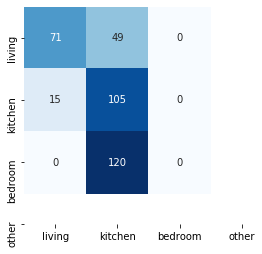

In [33]:
kondo1(X_test, y_test, model)

# ランダムフォレスト

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=1000)
clf = clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = clf.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = clf.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

In [ ]:
kondo1(X_test, y_test, clf)

# LightGBM

In [ ]:
import lightgbm as lgb
gbm = lgb.LGBMClassifier(
    objective='binary',
    num_leaves=10,
    min_child_samples=20,
    max_depth=15
)
gbm = gbm.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = gbm.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = gbm.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

In [ ]:
kondo1(X_test, y_test, gbm)

# 1つにまとめてしまおう

In [ ]:
def models(X_train, y_train, X_test, y_test, random=None):
    from sklearn.metrics import accuracy_score
    
    #SVM
    from sklearn.svm import SVC
    svm = SVC(kernel='rbf', random_state=random).fit(X_train, y_train)
    pred_train_svm = svm.predict(X_train)
    accuracy_train_svm = accuracy_score(y_train, pred_train_svm)
    print('トレーニングデータ_SVM： %.2f' % accuracy_train_svm)
    pred_test_svm = svm.predict(X_test)
    accuracy_test_svm = accuracy_score(y_test, pred_test_svm)
    print('テストデータ_SVM： %.2f' % accuracy_test_svm)
    
    #RandomForest
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.datasets import make_classification

    forest = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=14,).fit(X_train, y_train)
    pred_train_forest = forest.predict(X_train)
    accuracy_train_forest = accuracy_score(y_train, pred_train_forest)
    print('トレーニングデータ_RandomForest： %.2f' % accuracy_train_forest)
    pred_test_forest = forest.predict(X_test)
    accuracy_test_forest = accuracy_score(y_test, pred_test_forest)
    print('テストデータ_RandomForest： %.2f' % accuracy_test_forest)
    
    #LightGBM
    import lightgbm as lgb
    gbm = lgb.LGBMClassifier(
        objective='binary',
        num_leaves=10,
        min_child_samples=20,
        max_depth=15
    ).fit(X_train, y_train)
    pred_train_gbm = gbm.predict(X_train)
    accuracy_train_gbm = accuracy_score(y_train, pred_train_gbm)
    print('トレーニングデータ_gbm： %.2f' % accuracy_train_gbm)
    pred_test_gbm = gbm.predict(X_test)
    accuracy_test_gbm = accuracy_score(y_test, pred_test_gbm)
    print('テストデータ_gbm： %.2f' % accuracy_test_gbm)
    
    return svm, forest, gbm

In [ ]:
svm, forest, gbm = models(X_train, y_train, X_test, y_test, random=None)

In [ ]:
kondo1(X_test, y_test, svm)

# 訓練データにかたよりがあるのでどうにかする

In [ ]:
print("リビング",len(df[df["label"]==0]))
print("キッチン",len(df[df["label"]==1]))
print("寝室",len(df[df["label"]==2]))
print("その他",len(df[df["label"]==3]))

## ダウンサンプリング
一番ラベルの数が少ないのは2なので、0はliv倍、1はkit倍, 2はbed倍してる。(liv,bedは整数)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

positive_count_train = y_train.value_counts()[2] #リビング=0の数

liv=2
kit=2
bed=1
strategy = {0:positive_count_train*liv, 1:positive_count_train*kit, 2:positive_count_train*bed}

rus = RandomUnderSampler(random_state=77, sampling_strategy = strategy)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
y_resampled.value_counts()

In [ ]:
from sklearn.svm import SVC
model2 = SVC(kernel='linear', random_state=None)

model2 = model.fit(X_resampled, y_resampled)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model2.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model2.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

In [ ]:
kondo1(X_test, y_test, model2)

## リビングの精度が悪い！
テレビは同じなのにどうして…

## テレビの音声だけでテストしてみる

In [ ]:
df_ATJ

In [ ]:
df_ATJ_nonVoice = df_ATJ[df_ATJ["action"] != 1]
df_ATJ_nonVoice

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df_use.iloc[:, :-2], dtype = float))
y_train = df_use["label"]
X_test = scaler.fit_transform(np.array(df_ATJ_nonVoice.iloc[:, :-4], dtype = float))
y_test = df_ATJ_nonVoice["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

In [ ]:
kondo1(X_test, y_test, model)

### テレビをテレビと認識しない…

In [ ]:
df_ATJ_nonTV = df_ATJ[df_ATJ["action"] != 0]
#df_ATJ_nonTV

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df_use.iloc[:, :-2], dtype = float))
y_train = df_use["label"]
X_test = scaler.fit_transform(np.array(df_ATJ_nonTV.iloc[:, :-4], dtype = float))
y_test = df_ATJ_nonTV["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

In [ ]:
kondo1(X_test, y_test, model)